# 7장 에이다부스트 메타 알고리즘으로 분류 개선하기

## < 학습 목표 >
* 성능 향상을 위해 유사한 분류기 결합하기
* 에이다부스트 알고리즘 적용하기
* 분류 불균형 처리하기

## 7.1 데이터 집합의 다양한 표본을 사용하는 분류기
### 7.1.1 배깅: 임의초 추출한 재표본 데이터로부터 분류기 구축하기
### 7.1.2 부스팅

## 7.2 훈련: 오류에 초점을 맞춘 분류기 개선

## 7.3 의사결정 스텀프로 약한 학습기 생성하기
#### <span style="color:Blue"><b>리스팅 7.1 의사결정 스텀프 생성 함수</b></span>

## 7.4 전체 에이다부스트 알고리즘 구현하기
#### <span style="color:Blue"><b>리스팅 7.2 의사결정 스텀프로 에이다부스트 검사</b></span>

## 7.5 검사: 에이다부스트로 분류하기
#### <span style="color:Blue"><b>리스팅 7.3 에이다부스트 분류 함수</b></span>

## 7.6 예제: 에이다부스트에 복잡한 데이터 집합 적용하기
#### <span style="color:Blue"><b>리스팅 7.4 에이다부스트를 위해 데이터를 불러오는 함수</b></span>

## 7.7 분류 불균형
### 7.7.1 또 다른 성능 측정 방법: 정확도, 재현율 그리고 ROC
#### <span style="color:Blue"><b>리스팅 7.5 ROC 플롯과 AUC 계산 함수</b></span>
### 7.7.2 비용 함수를 가진 분류기의 의사결정 다루기
### 7.7.3 분류 불균형이 있는 데이터를 처리하기 위한 데이터 샘플링
## 7.8 요약

## 7.1 데이터 집합의 다양한 표본을 사용하는 분류기

### 7.1.1 배깅: 임의로 추출한 재표본 데이터로부터 분류기 구축하기

### 7.1.2 부스팅 

## 7.2 훈련: 오류에 초점을 맞춘 분류기 개선

## 7.3 의사결정 스텀프로 약한 학습기 생성하기

In [20]:
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [22]:
dataMat, classLabels = loadSimpData()

#### 리스팅 7.1 의사결정 스텀프 생성 함수

In [70]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [71]:
D = mat(ones((5,1))/5)

In [72]:
buildStump(dataMat, classLabels, D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 7.4 전체 에이다부스트 알고리즘 구현하기

#### 리스팅 7.2 의사결정 스텀프로 에이다부스트 검사

In [67]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        print "D:",D.T
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print "total error: ",errorRate
        if errorRate == 0.0: break
    return weakClassArr

In [68]:
classifierArray = adaBoostTrainDS(dataMat, classLabels, 9)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineq

In [69]:
classifierArray

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273,
  'dim': 0,
  'ineq': 'lt',
  'thresh': 0.90000000000000002}]

## 7.5 검사: 에이다부스트로 분류하기

#### 리스팅 7.3 에이다부스트 분류 함수

In [29]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        print aggClassEst
    return sign(aggClassEst)

In [33]:
datArr, labelArr = loadSimpData()

In [35]:
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)

total error:  0.2
total error:  0.2
total error:  0.0


In [36]:
adaClassify([0,0], classifierArr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [37]:
adaClassify([[5,5],[0,0]], classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

## 7.6 예제: 에이다부스트에 복잡한 데이터 집합 적용하기

#### 리스팅 7.4 에이다부스트를 위해 데이터를 불러오는 함수

In [38]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [39]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [42]:
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.284280936455
total error:  0.284280936455
total error:  0.247491638796
total error:  0.247491638796
total error:  0.254180602007
total error:  0.240802675585
total error:  0.240802675585
total error:  0.220735785953
total error:  0.247491638796
total error:  0.230769230769


In [41]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')

In [43]:
prediction10 = adaClassify(testArr, classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [44]:
errArr = mat(ones((67,1)))

In [45]:
errArr[prediction10 != mat(testLabelArr).T].sum()

16.0

## 7.7 분류 불균형

### 7.7.1 또 다른 성능 측정 방법: 정확도, 재현율 그리고 ROC

#### 리스팅 7.5 ROC 플롯과 AUC 계산 함수

In [50]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print "total error: ",errorRate
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst

In [51]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print "the Area Under the Curve is: ",ySum*xStep


In [56]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [57]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.284280936455
total error:  0.284280936455
total error:  0.247491638796
total error:  0.247491638796
total error:  0.254180602007
total error:  0.240802675585
total error:  0.240802675585
total error:  0.220735785953
total error:  0.247491638796
total error:  0.230769230769


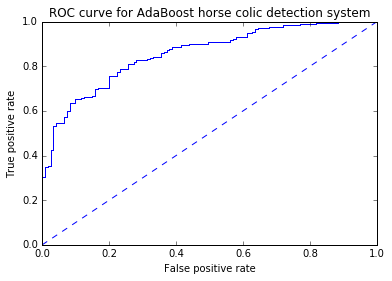

the Area Under the Curve is:  0.858296963506


In [61]:
% matplotlib inline

plotROC(aggClassEst.T, labelArr)

### 7.7.2 비용 함수를 가진 분류기의 의사결정 다루기

### 7.7.3 분류 불균형이 있는 데이터를 처리하기 위한 데이터 샘플링

## 7.8 요약

* <span style="color:Blue"><b>앙상블 메소드</b></span>는 간단하게 하나의 분류기를 사용하는 것보다 더 좋은 답을 구하기 위해서 다양한 분류기들의 예측을 결합하는 방법
 - 다양한 분류기를 결합하는 것은 과적합과 같은 단일 분류기의 단점을 공략하는 방법
 - 분류기들이 서로 큰 차이를 보일 때, 다양한 분류기들을 결합하는 것은 효과적임
* 앙상블 메소드의 두 가지 유형 - 배깅 & 부스팅
 - 배깅: 대체할 데이터 집합을 위해 원본 데이터 집합과 같은 크기의 데이터 집합을 임의로 추출한 예제들로 구축
 - 부스팅: 하나의 데이터 집합에 순차적으로 서로 다른 여러 가지 분류기를 적용함으로써 단계를 추가하는 배깅의 발상 적용
* <font color="Blue"><b>에이다부스트</b></font>는 약한 학습기를 사용
 - 약한 학습기는 가중치 벡터에 의해 가중치가 부여된 입력 데이터를 분류함
 - 첫 번째 반복에서는 모든 데이터에 같은 가중치가 부여되지만, 그 다음 반복부터는 이전에 부정확하게 분류된 데이터에 대해 더 높은 가중치가 부여됨
 - 이처럼 오류에 적응하는 것이 에이다부스트의 장점
* 에이다부스트 함수는 어떠한 분류기든 가중치가 부여된 데이터를 처리할 수 있도록 적용할 수 있음
 - 에이다부스트 알고리즘의 성능은 강력하며, 다른 분류기에 사용하기 어려운 데이터 집합도 빠르게 다룸
* 분류 불규형 문제는 긍정적인 예제와 부정적인 예제의 개수가 동일하지 않은 데이터를 가지고 분류기를 훈련할 때 발생
 - 분류 불균형 문제는 분류가 잘못되었을 때, 긍정적인 예제와 부정적인 예제에 대한 비용이 서로 다를 경우에도 발생하게 됨
  - 서로 다른 분류기를 평가하는 방법으로 ROC 곡선을 이용
  - 어떤 하나의 분류 항목으로 분류하는 것이 이와 다른 분류 항목으로 분류하는 것보다 더 중요할 경우, 분류기의 성능을 통계적으로 측정하기 위해 정확도와 재현율을 사용